
# Prediksi Risiko Stroke Menggunakan Random Forest (Model Utama) vs Logistic Regression (Baseline)

Notebook ini dibuat mengikuti isi proposal **“Prediksi Risiko Stroke Menggunakan Random Forest untuk Mendukung Deteksi Dini”**:
- Dataset: **Stroke Prediction Dataset (Kaggle)** (versi yang sudah dibersihkan, termasuk BMI)  
- Tugas: **klasifikasi biner** risiko stroke *(0 = tidak stroke, 1 = stroke)*  
- Model: **Random Forest** (utama) dan **Logistic Regression** (baseline)  
- Penanganan *imbalanced class*: **train-test split stratified**  
- Evaluasi: **Accuracy, Precision, Recall, F1-score, ROC-AUC, Confusion Matrix, ROC Curve**  
- Analisis: **Feature Importance** (Random Forest)  
- Luaran: **model tersimpan (.joblib)** untuk deployment (Streamlit sesuai proposal)

> Pastikan file dataset tersedia. Pada percakapan ini tersedia file: `/mnt/data/stroke_clean_ready.csv`


In [ ]:

# (Opsional) install dependency jika diperlukan
# !pip install -U pandas numpy scikit-learn matplotlib joblib


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)



## 1) Load Dataset

Notebook akan mencoba membaca file dataset dari path berikut (urutan prioritas):
1. `/mnt/data/stroke_clean_ready.csv`  *(default di environment ini)*  
2. `stroke_clean_ready.csv` (di folder kerja)  
3. `healthcare-dataset-stroke-data.csv` (nama umum dataset Kaggle)  


In [2]:

CANDIDATE_PATHS = [
    "/mnt/data/stroke_clean_ready.csv",
    "stroke_clean_ready.csv",
    "healthcare-dataset-stroke-data.csv",
    "stroke_data.csv",
]

data_path = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if data_path is None:
    raise FileNotFoundError(
        "Dataset tidak ditemukan. Letakkan salah satu file berikut di folder kerja: "
        + ", ".join(CANDIDATE_PATHS)
    )

df = pd.read_csv(data_path)
print("Loaded:", data_path)
print("Shape:", df.shape)
df.head()


Loaded: stroke_clean_ready.csv
Shape: (5109, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



## 2) Cek Struktur Data & Distribusi Target (Imbalanced Check)


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.2+ KB


In [4]:

target_col = "stroke"
if target_col not in df.columns:
    raise ValueError(f"Kolom target '{target_col}' tidak ditemukan. Kolom tersedia: {list(df.columns)}")

df[target_col].value_counts().rename_axis("stroke").to_frame("count")


,count
stroke,
0,4860
1,249


In [5]:

pos_rate = df[target_col].mean()
print(f"Proporsi stroke=1: {pos_rate:.4f} ({pos_rate*100:.2f}%)")


Proporsi stroke=1: 0.0487 (4.87%)



## 3) Pisahkan Fitur (X) dan Target (y)

Sesuai proposal, fitur mengikuti atribut yang tersedia di dataset (mis. umur, hipertensi, penyakit jantung, glukosa, BMI, status merokok, dll.).


In [6]:

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# (Opsional) drop kolom id jika ada
if "id" in X.columns:
    X = X.drop(columns=["id"])

X.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked



## 4) Train-Test Split (Stratified)

Menggunakan `stratify=y` agar proporsi kelas pada train dan test tetap seimbang (sesuai proposal untuk menangani data imbalance).


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape, " | Pos rate:", y_train.mean())
print("Test  shape:", X_test.shape,  " | Pos rate:", y_test.mean())


Train shape: (4087, 10)  | Pos rate: 0.04869097137264497
Test  shape: (1022, 10)  | Pos rate: 0.04892367906066536



## 5) Preprocessing (Tabular)

- **Numerik**: imputasi median (aman walau dataset sudah bersih), lalu scaling (StandardScaler)  
- **Kategorikal**: imputasi modus, lalu One-Hot Encoding  


In [8]:

# Deteksi kolom kategorikal vs numerik
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numeric columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']



## 6) Build Model

- Baseline: **Logistic Regression**
- Model utama: **Random Forest**

Catatan: Untuk data imbalance, selain stratified split, kita juga set `class_weight="balanced"` (umum dipakai agar penalti untuk kelas minoritas lebih besar).


In [9]:

logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_jobs=-1
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", logreg),
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])



## 7) Training


In [10]:

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

print("Training selesai.")


Training selesai.



## 8) Evaluasi Model (Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix, ROC Curve)

Sesuai proposal, kita hitung metrik berikut:
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- Confusion Matrix
- ROC Curve


MODEL: Logistic Regression (Baseline)
accuracy     0.737769
precision    0.134228
recall            0.8
f1           0.229885
roc_auc      0.839321
dtype: object

Classification Report:
              precision    recall  f1-score   support

           0     0.9862    0.7346    0.8420       972
           1     0.1342    0.8000    0.2299        50

    accuracy                         0.7378      1022
   macro avg     0.5602    0.7673    0.5359      1022
weighted avg     0.9445    0.7378    0.8120      1022



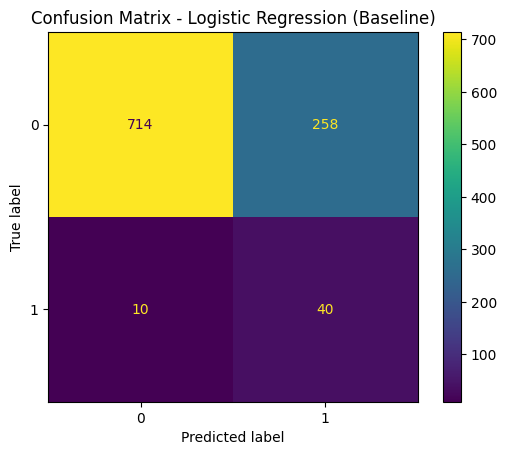

MODEL: Random Forest (Utama)
accuracy     0.950098
precision         0.0
recall            0.0
f1                0.0
roc_auc      0.787356
dtype: object

Classification Report:
              precision    recall  f1-score   support

           0     0.9510    0.9990    0.9744       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9501      1022
   macro avg     0.4755    0.4995    0.4872      1022
weighted avg     0.9045    0.9501    0.9267      1022



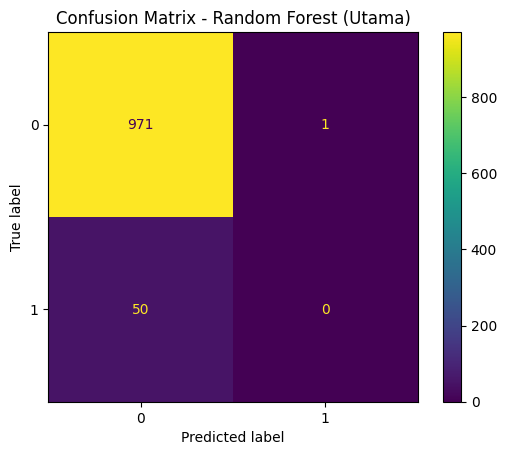

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression (Baseline),0.737769,0.134228,0.8,0.229885,0.839321
Random Forest (Utama),0.950098,0.000000,0.0,0.000000,0.787356


In [11]:

def evaluate_binary_classifier(model, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    
    # ROC-AUC butuh probabilitas kelas positif
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        # fallback untuk model yg tidak punya predict_proba
        y_proba = model.decision_function(X_te)
        # normalisasi ke [0,1] jika diperlukan (optional)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_proba),
    }
    cm = confusion_matrix(y_te, y_pred)

    print("="*80)
    print(f"MODEL: {name}")
    print(pd.Series(metrics).drop("model"))
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, digits=4, zero_division=0))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    return metrics, y_proba

metrics_lr, proba_lr = evaluate_binary_classifier(pipe_lr, X_test, y_test, name="Logistic Regression (Baseline)")
metrics_rf, proba_rf = evaluate_binary_classifier(pipe_rf, X_test, y_test, name="Random Forest (Utama)")

results = pd.DataFrame([metrics_lr, metrics_rf]).set_index("model")
results


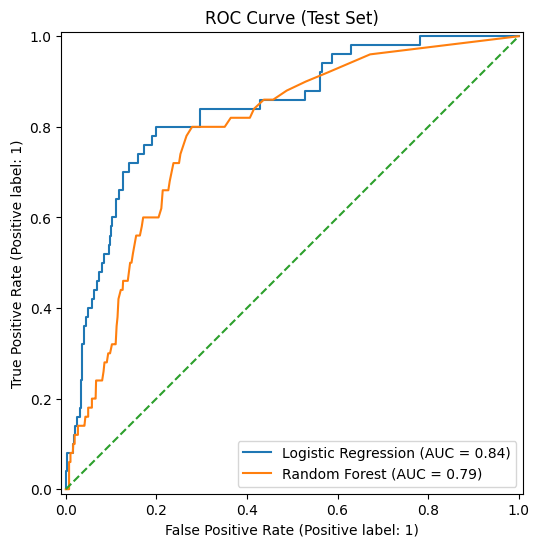

In [12]:

# Plot ROC Curve (dua model dalam satu grafik)
fig, ax = plt.subplots(figsize=(7, 6))

RocCurveDisplay.from_predictions(y_test, proba_lr, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(y_test, proba_rf, name="Random Forest", ax=ax)

ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curve (Test Set)")
plt.show()



## 9) Feature Importance (Random Forest)

Mengambil *feature importance* dari Random Forest untuk mengetahui faktor yang paling berpengaruh (sesuai proposal).


In [13]:

# Ambil feature names setelah preprocessing (one-hot + numerik)
# Catatan: get_feature_names_out tersedia di sklearn versi modern.
feature_names = pipe_rf.named_steps["preprocess"].get_feature_names_out()

importances = pipe_rf.named_steps["model"].feature_importances_
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
0,num__age,0.371395
3,num__avg_glucose_level,0.183401
4,num__bmi,0.168033
1,num__hypertension,0.032012
8,cat__ever_married_Yes,0.024045
7,cat__ever_married_No,0.022488
2,num__heart_disease,0.020970
12,cat__work_type_Self-employed,0.017971
18,cat__smoking_status_never smoked,0.017351
11,cat__work_type_Private,0.015367


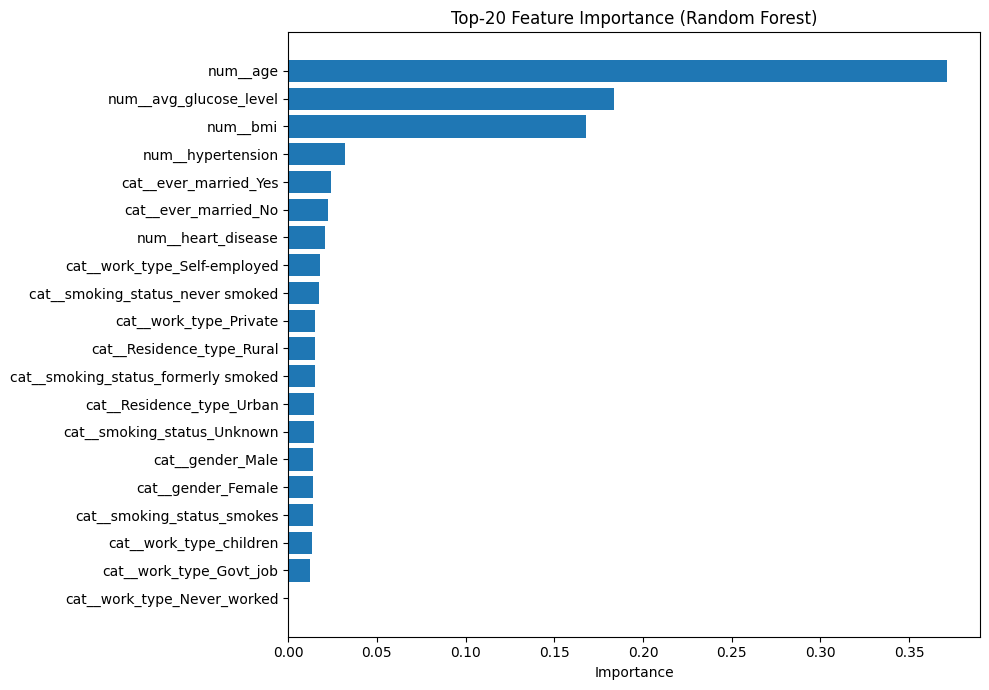

In [14]:

# Plot top-20 feature importance
top_k = 20
fi_top = fi.head(top_k).iloc[::-1]  # dibalik agar bar chart dari kecil ke besar

plt.figure(figsize=(10, 7))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title(f"Top-{top_k} Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



## 10) Simpan Model Terbaik (Pipeline) untuk Deployment

Model disimpan dalam bentuk pipeline (preprocess + model), sehingga saat inference tidak perlu mengulang encoding/scaling manual.


In [16]:
# Pilih model terbaik berdasarkan ROC-AUC
best_name = results["roc_auc"].idxmax()
best_model = pipe_rf if best_name.startswith("Random Forest") else pipe_lr

print("Best model (by ROC-AUC):", best_name)

model_path = "stroke_risk_model.joblib"   # <-- tanpa folder "models"
joblib.dump(best_model, model_path)

print("Saved model to:", os.path.abspath(model_path))


Best model (by ROC-AUC): Logistic Regression (Baseline)
Saved model to: c:\INDRA\MESIN\TUGAS BESAR RANDY\stroke_risk_model.joblib
